# INTENT CHARACTERIZATION

TO DO :  
    * track pipeline w/ airflow  
* **workload**: 
    * 4 hours

In [2]:
import pandas as pd
import time
import numpy as np

# visualization
from matplotlib import pyplot as plt

# preprocessing
import spacy
from spacy import tokenizer
from spacy.lang.en import English

# exploration
import re
from ipywidgets import interact

In [4]:
# display
pd.set_option("display.max_colwidth", 10)

In [6]:
proj_path = "/Users/steeve_laquitaine/desktop/CodeHub/intent/intent/"
train_data_path = proj_path + "data/01_raw/banking77/train.csv"
test_data_path = proj_path + "data/01_raw/banking77/test.csv"

In [8]:
train_data  = pd.read_csv(train_data_path)

In [10]:
# preview
train_data.head(5)

,text,category
0,I am s...,card_a...
1,What c...,card_a...
2,I have...,card_a...
3,Can I ...,card_a...
4,How do...,card_a...


In [12]:
print('{} unique labels'.format(train_data.category.nunique()))
print(train_data.category.unique())

77 unique labels
['card_arrival' 'card_linking' 'exchange_rate'
 'card_payment_wrong_exchange_rate' 'extra_charge_on_statement'
 'pending_cash_withdrawal' 'fiat_currency_support'
 'card_delivery_estimate' 'automatic_top_up' 'card_not_working'
 'exchange_via_app' 'lost_or_stolen_card' 'age_limit' 'pin_blocked'
 'contactless_not_working' 'top_up_by_bank_transfer_charge'
 'pending_top_up' 'cancel_transfer' 'top_up_limits'
 'wrong_amount_of_cash_received' 'card_payment_fee_charged'
 'transfer_not_received_by_recipient' 'supported_cards_and_currencies'
 'getting_virtual_card' 'card_acceptance' 'top_up_reverted'
 'balance_not_updated_after_cheque_or_cash_deposit'
 'card_payment_not_recognised' 'edit_personal_details'
 'why_verify_identity' 'unable_to_verify_identity' 'get_physical_card'
 'visa_or_mastercard' 'topping_up_by_card' 'disposable_card_limits'
 'compromised_card' 'atm_support' 'direct_debit_payment_not_recognised'
 'passcode_forgotten' 'declined_cash_withdrawal' 'pending_card_payme

Took 0.33 secs


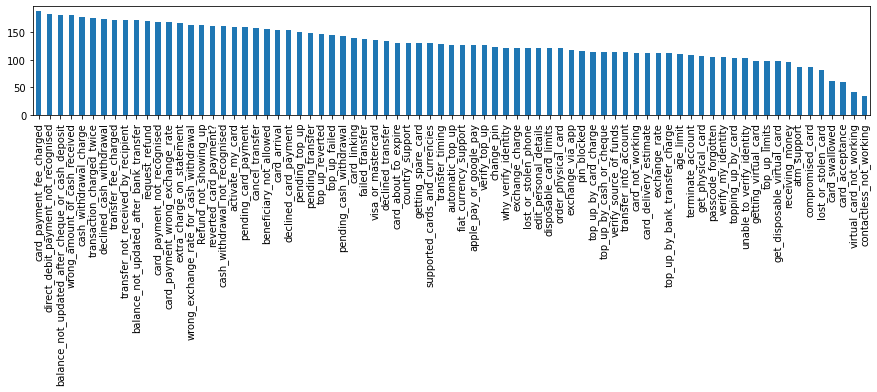

In [16]:
tic = time.time()
train_data.category.value_counts().plot(
    kind='bar', 
    # y=train_data.category.value_counts().index, 
    # x=train_data.category.value_counts().values, 
    figsize=(15,2)
    );
print('Took {} secs'.format(np.round(time.time()-tic,2)))    

Took 0.22 secs


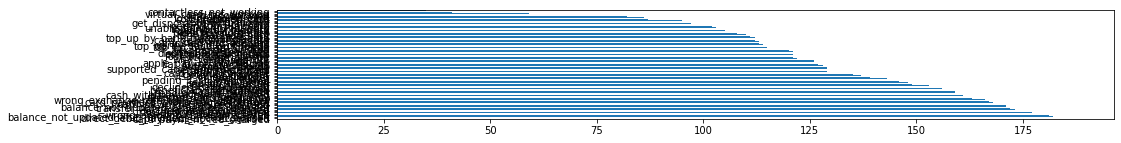

In [40]:
# horizontal plot
tic = time.time()
train_data.category.value_counts().plot.barh(
    figsize=(15,2)
    );
print('Took {} secs'.format(np.round(time.time()-tic,2)))    

In [21]:
# list labels sorted by occurrence frequency
intents_by_popularity = train_data.category.value_counts().index.tolist()
intents_by_popularity[:10]

['card_payment_fee_charged',
 'direct_debit_payment_not_recognised',
 'balance_not_updated_after_cheque_or_cash_deposit',
 'wrong_amount_of_cash_received',
 'cash_withdrawal_charge',
 'transaction_charged_twice',
 'declined_cash_withdrawal',
 'transfer_fee_charged',
 'transfer_not_received_by_recipient',
 'balance_not_updated_after_bank_transfer']

In [24]:
# show top intent requests
top_label_data = train_data.text.loc[train_data.category==intents_by_popularity[0]]
top_label_data.tolist()[:10]

['There was a fee charged when I paid with my card.',
 'I received a fee I should not have.',
 'Why am I being a charged for using my card?',
 'Tell me why there is a fee for a card payment.',
 "I don't understand why I'm being charged for using my card.",
 'I paid with my card so so why was I charged a transaction fee?',
 "I shouldn't have been charged but I see a fee, why?",
 'i made a payment with my card and was charged a fee, why would you do that',
 'A fee came along with me paying with card',
 'I had to pay a fee when buying items with my card.']

# Explore vocabulary

In [27]:
# convert data Series to one data String
data_string = " ".join(top_label_data.to_list())

In [29]:
# tokenize text
def tokenize_txt(data_string, tokenizer, English):
    tokenize = tokenizer.Tokenizer(English().vocab)
    tokens = tokenize(data_string)
    print("{} tokens".format(len(tokens)))
    return tokens
tokens = tokenize_txt(data_string, tokenizer, English)        

2619 tokens


In [31]:
print(list(tokens[:100]))

[There, was, a, fee, charged, when, I, paid, with, my, card., I, received, a, fee, I, should, not, have., Why, am, I, being, a, charged, for, using, my, card?, Tell, me, why, there, is, a, fee, for, a, card, payment., I, don't, understand, why, I'm, being, charged, for, using, my, card., I, paid, with, my, card, so, so, why, was, I, charged, a, transaction, fee?, I, shouldn't, have, been, charged, but, I, see, a, fee,, why?, i, made, a, payment, with, my, card, and, was, charged, a, fee,, why, would, you, do, that, A, fee, came, along, with, me, paying]


# Describe requests

* Clause features:

  1. **Type**  
    
        * interrogative (1)
            * closed
            * open
        * declarative
        * imperative (2)
            * wishes  
            * orders  
        * exclamative
        
  2. **Length**

  3. **Structural complexity (3)**  
        * simple  
        * compound    
        * complex  
        * compound-complex  

In [33]:
top_intent = intents_by_popularity[0]
top_intent_text = train_data.text[train_data.category.eq(top_intent)].tolist()
top_intent_text[:10]

['There was a fee charged when I paid with my card.',
 'I received a fee I should not have.',
 'Why am I being a charged for using my card?',
 'Tell me why there is a fee for a card payment.',
 "I don't understand why I'm being charged for using my card.",
 'I paid with my card so so why was I charged a transaction fee?',
 "I shouldn't have been charged but I see a fee, why?",
 'i made a payment with my card and was charged a fee, why would you do that',
 'A fee came along with me paying with card',
 'I had to pay a fee when buying items with my card.']

### Sentence types

In [35]:
# either ? or ! or .
SENT_TYPE_PATTN = re.compile(r"[\?\!\.]")

def classify_sentence_type(sentences):
    """
    Classify sentence type
    """
    sent_type = []
    for sent in sentences:
        out = SENT_TYPE_PATTN.findall(sent)
        sent_type.append(['ask' if ix=='?' else 'wish-or-excl' if ix=='!' else 'state' for ix in out])        
    return sent_type


def detect_sentence_type(df, sent_type:str):
    """
    Detect sentence types

    parameters
    ----------
    sent_type: str
        'state', 'ask', 'wish-excl' 
    """
    return sent_type in df

sentence_type = classify_sentence_type(train_data.text.tolist())
train_data_feat = train_data.copy()
train_data_feat["sentence_type"] = sentence_type

In [37]:
# filter sentences by "type"
TYPE = 'ask'
filtered = train_data_feat[train_data_feat.apply(lambda x: detect_sentence_type(x.sentence_type, TYPE), axis=1)]
filtered

,text,category,sentence_type
0,I am s...,card_a...,[ask]
1,What c...,card_a...,[ask]
2,I have...,card_a...,[state...
3,Can I ...,card_a...,[ask]
4,How do...,card_a...,[ask]
...,...,...,...
9998,You pr...,countr...,[ask]
9999,What c...,countr...,[ask]
10000,What c...,countr...,[ask]
10001,Are ca...,countr...,[ask]


In [39]:
sent_types = ['state', 'ask', 'wish-or-excl']
data = train_data_feat

button = widgets.Button(description="Click Me!")
display(button)

@interact(WINDOW_START=(0, 100))
def show_text_SideBySide(WINDOW_START):
    """
    Show texts in dataframe side by side  
    
    INPUT:
    -----
    sent_types: list
    data: pd.DataFrame

    RETURN:    
    ------
    ipywidget object to display 
        display(show_text_SideBySide( ... ))
    """    
    pd.set_option("display.max_colwidth", -1)   #show entire text  
    widget_all = []
    count = -1
    while count < len(sent_types)-1:        
        count += 1        
        widget_all.append(widgets.Output())    #init Outputs widgets
        selected_df = data[['text']][  #select data by sent_type
            data.apply(
                lambda x: detect_sentence_type(
                    x.sentence_type, sent_types[count]
                    ), 
                    axis=1
                )
            ].iloc[WINDOW_START:WINDOW_START+10]
        with widget_all[count]: 
            clear_output(True)
            # print("Button clicked.",round(random.uniform(0, 1),3))
            display(selected_df)
    return widgets.HBox(widget_all)

button.on_click(show_text_SideBySide)

NameError: name 'widgets' is not defined

In [286]:
# from IPython.display import clear_output
# button = widgets.Button(description="Click Me!")
# out = widgets.Output()
# display(button)
# display(out)

# def on_button_clicked(b):
#     with out:
#         clear_output(True)
#         print("Button clicked.",round(random.uniform(0, 1),3))

# button.on_click(on_button_clicked)


# References

(1) https://allthingslinguistic.com/post/160783915317/being-a-declarative-or-interrogative-or  
(2) https://oxford.universitypressscholarship.com/view/10.1093/acprof:oso/9780199283613.001.0001/acprof-9780199283613-chapter-6   
(3) Fareh, S., & Moussa, M. B. (2008). Pragmatic Functions of Interrogative Sentences in English: A Corpus-based Study. International Journal of Arabic-English Studies, 9(1), 145-164.   